In [ ]:
import os
import cv2
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt

import SimpleITK as stk

In [1]:
import tensorflow as tf
tf.__version__

'2.10.0'

In [286]:
root = "data/luna16/"
root_images = "data/luna16/original/"

In [287]:
def load_mhd(file):
    mhdimage = stk.ReadImage(file)
    ct_scan = stk.GetArrayFromImage(mhdimage)    # indexes are z,y,x
    origin = np.array(mhdimage.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    space = np.array(mhdimage.GetSpacing())      # spacing of voxels in world coor. (mm)
    return ct_scan, origin, space

In [288]:
# subset = 0    # Ran for 0...9
num_subsets = 11    # Ran for 0...9
file_list = []

# file_list = glob(root_images+f"subset{subset}/*.mhd")
for subset in range(num_subsets):
    file_list.extend(glob(root_images + f"subset{subset}/*.mhd"))

annotations_df = pd.read_csv(root + "modif-annotations.csv")
print("Files Count:",len(file_list))
print("DF Count:",len(annotations_df))

# # Extract filenames without the path and without the .mhd extension
# file_names = [os.path.splitext(os.path.basename(file_path))[0] for file_path in file_list]
# print(file_names)

# # Filter rows in annotations_df where "seriesuid" is in the list of file_names
# filtered_annotations_df = annotations_df[annotations_df["seriesuid"].isin(file_names)]

# # Now, filtered_annotations_df contains only the rows with "seriesuid" matching the file_names
# print(filtered_annotations_df)

annotations_df.head()

annotations_df_check = annotations_df

Files Count: 692
DF Count: 1186


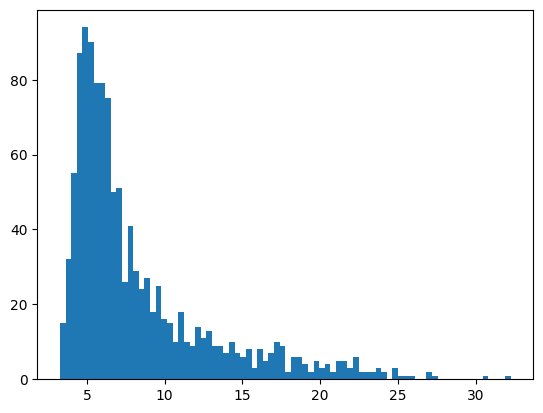

In [289]:
d = annotations_df['diameter_mm'].values
fig = plt.hist(d, bins=80)

In [290]:
def get_filename(file_list, file):
    for f in file_list:
        if file in f:
            return f

In [291]:

annotations_df["filename"] = annotations_df["seriesuid"].map(lambda file: get_filename(file_list, file))
annotations_df = annotations_df.dropna()
# annotations_df = annotations_df[annotations_df['diameter_mm']>=3.9]     # Excluding nodules with diameter less than 3.9mm
print(len(annotations_df))
print(len(annotations_df_check))

958
1186


In [ ]:
# # ############### Check where rows that dont have file


# # Merge the DataFrames using an outer join and indicator=True
# merged_df = pd.merge(annotations_df_check, annotations_df, how='outer', indicator=True)

# # Filter rows that are only in annotations_df_check
# rows_only_in_annotations_df_check = merged_df[merged_df['_merge'] == 'left_only']

# # Filter rows that are only in annotation_normal
# rows_only_in_annotation_normal = merged_df[merged_df['_merge'] == 'right_only']

# # Display the results or perform further analysis
# print("Rows only in annotations_df_check:")
# print(rows_only_in_annotations_df_check)

# print("\nRows only in annotation_normal:")
# print(rows_only_in_annotation_normal)

# # # Define the CSV file path where you want to save the data
# # csv_file_path_test = root + 'output3/not-included.csv'

# # # Save the DataFrame to a CSV file
# # rows_only_in_annotations_df_check.to_csv(csv_file_path_test, index=False)

In [292]:
# annotations_df.head()

# # Define the CSV file path where you want to save the data
# csv_file_path = root + 'check-annot-fix.csv'

# # Save the DataFrame to a CSV file
# annotations_df.to_csv(csv_file_path, index=False)

In [ ]:
def display(imgs, titles=None, cmap="bone"):
    n = len(list(imgs))
    r = n//4 if n%4==0 else (n//4)+1
    plt.figure(figsize=(25,14))
    for i,img in enumerate(imgs):
        plt.subplot(r,4,i+1)
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(img, cmap=cmap)

In [ ]:
# def display_mask(imgs, masks, titles=None, cmap="bone"):
#     n = len(list(imgs))
#     # n = 12
#     r = n//2 if n%2==0 else (n//2)+1
#     plt.figure(figsize=(20,40))
#     for i,(img, mask) in enumerate(zip(imgs,masks)):
#         plt.subplot(r,2,i+1)
#         ig = np.hstack((img, mask))
#         if titles is not None:
#             plt.title(titles[i])
#         plt.imshow(ig, cmap=cmap)

def display_mask_in_batches(imgs, masks, titles=None, cmap="bone", batch_size=6):
    n = len(list(imgs))
    num_batches = (n + batch_size - 1) // batch_size

    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = min((batch + 1) * batch_size, n)

        r = end_idx - start_idx
        plt.figure(figsize=(20, 4 * r))

        for i, (img, mask) in enumerate(zip(imgs[start_idx:end_idx], masks[start_idx:end_idx])):
            plt.subplot(r, 2, i + 1)
            ig = np.hstack((img, mask))
            if titles is not None:
                plt.title(titles[i + start_idx])
            plt.imshow(ig, cmap=cmap)

        plt.show()

In [296]:
annotations_df = pd.read_csv(root + "check-annot.csv")
annotations_df.head()
print("DF Count:",len(annotations_df))
annotations_df.head()

DF Count: 1


,id,seriesuid,coordX,coordY,coordZ,diameter_mm,filename
0,A00371,1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233...,-47.89877,-10.22492,-96.113602,20.159984,data/luna16/original/subset9\1.3.6.1.4.1.14519...


In [297]:
def make_mask(img, center, diam):
    mask = np.zeros_like(img, dtype=np.uint8)
    mask = cv2.circle(mask, (int(center[0]),int(center[1])), diam//2, 255, -1)
    return mask

In [298]:
masks = []
imgs = []
tt = -1
v_centers = []
v_diameters = []
id_patient = []
ct_scan = []
origin_image = []
spacing_image = []
imgs_cropped = []
masks_cropped = []

imgs_ori = []
imgs_cropped_ori = []

#original annotations
series_id = []
nodes_x = []
nodes_y = []
nodes_z = []
diameters = []

# Define the size of the crop (64x64)
crop_size = 64

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

for i,file in tqdm(enumerate(np.unique(annotations_df['filename'].values))):
    annotations = annotations_df[annotations_df["filename"]==file]
    ct, origin, spacing = load_mhd(file)

    # print(spacing)

    num_z, height, width = ct.shape
    # print(annotations.shape)
    # print(annotations)
    # print(file)

    p_vcenter = None
    tt += 1
    for j, mask_i in annotations.iterrows():
        serie_id = mask_i["seriesuid"]
        node_x = int(mask_i["coordX"])
        node_y = int(mask_i["coordY"])
        node_z = int(mask_i["coordZ"])
        diam = int(mask_i["diameter_mm"])
        id = mask_i["id"]
        
        center = np.array([node_x, node_y, node_z])   # nodule center
        v_center = np.rint((center-origin)/spacing)   # nodule center in voxel space (still x,y,z ordering)
        # v_diam = int(diam/spacing[0])+5
        v_diam = int(diam/spacing[0])
        # print(v_center)
        img_norm = cv2.normalize(ct[int(v_center[2]),:,:], None, 0, 255, cv2.NORM_MINMAX)
        mask = make_mask(img_norm, v_center, v_diam)
        
        # Calculate the coordinates for cropping
        x_center, y_center = v_center[0], v_center[1]  # Assuming x and y are the first and second elements in v_center
        x1 = int(x_center - crop_size / 2)
        x2 = int(x_center + crop_size / 2)
        y1 = int(y_center - crop_size / 2)
        y2 = int(y_center + crop_size / 2)

        # Crop the image
        # img_cropped = img_norm[y1:y2, x1:x2]
        # mask_cropped = mask[y1:y2, x1:x2]
        
        # img_cropped_ori = img_cropped
        # img_norm_ori = img_norm

        # img_norm = clahe.apply(img_norm.astype(np.uint8))
        # mask = mask.astype(np.uint8)

        # img_cropped = clahe.apply(img_cropped.astype(np.uint8))
        # mask_cropped = mask_cropped.astype(np.uint8)

        if v_center[0] >= 0 or v_center[1] >= 0 : 
        # if v_center[0] <= 0 or v_center[1] <= 0 : 
            # imgs_cropped.append(img_cropped)
            # masks_cropped.append(mask_cropped)

            #save
            # imgs.append(img_norm)
            # masks.append(mask)
            
            # imgs_ori.append(img_norm_ori)
            # imgs_cropped_ori.append(img_cropped_ori)

            v_centers.append(list(v_center))
            v_diameters.append(v_diam)
            id_patient.append(id)
            # masks.append(mask_base)
            
            ct_scan.append(ct)
            origin_image.append(origin)
            spacing_image.append(spacing)

            #original annot
            series_id.append(serie_id)
            nodes_x.append(node_x)
            nodes_y.append(node_y)
            nodes_z.append(node_z)
            diameters.append(diam)


0it [00:00, ?it/s]


RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\1\sitk-build\ITK\Modules\IO\Meta\src\itkMetaImageIO.cxx:484:
ITK ERROR: MetaImageIO(0000013FB069FB80): File cannot be read: data/luna16/original/subset9\1.3.6.1.4.1.14519.5.2.1.6279.6001.194632613233275988184244485809.mhd for reading.
Reason: No such file or directory

In [ ]:
print(len(id_patient))
print(len(masks_cropped))

In [ ]:
################ check nodules that are wrong


# data = {'id': id_patient, 'seriesuid': series_id, 'coordX': nodes_x, 'coordY': nodes_y, 'coordZ': nodes_z, 'diameter_mm': diameters, 'v_centers': v_centers, 'v_diameters': v_diameters, 'ct': ct_scan, 'origin': origin_image, 'space' : spacing_image}

# df = pd.DataFrame(data)

# # Define the CSV file path where you want to save the data
# csv_file_path = root + 'output3/miss-coord.csv'

# # Save the DataFrame to a CSV file
# df.to_csv(csv_file_path, index=False)
    
# print(f'Data saved to {csv_file_path}')

In [ ]:
# display_mask(imgs_cropped, masks_cropped, titles=id_patient)
# display_mask(imgs, masks, titles=None)

# display_mask_in_batches(imgs_cropped_ori, masks_cropped, titles=id_patient, cmap="bone", batch_size=4)

In [ ]:
from sklearn.cluster import KMeans

masksi = []
kmeans_masks_cropped = []
print(len(imgs_cropped))
print(len(masks_cropped))

In [ ]:
# for i,m in zip(imgs,masks):
# for i,m in zip(imgs_cropped,masks_cropped):
#     e = cv2.bitwise_and(i,i,mask=cv2.dilate(m,kernel=np.ones((5,5))))
#     pts = e[e>0]
#     # centeral_area = i[100:400, 100:400]
#     kmeans = KMeans(n_clusters=2).fit(np.reshape(pts,(len(pts),1)))
#     # kmeans = KMeans(n_clusters=2).fit(np.reshape(centeral_area, [np.prod(centeral_area.shape), 1]))
#     centroids = sorted(kmeans.cluster_centers_.flatten())
#     threshold = np.mean(centroids)
#     # mk = cv2.bitwise_and(i, i, mask=m)
#     ret, lung_nod = cv2.threshold(e, threshold, 255, cv2.THRESH_BINARY)
#     lung_nod = lung_nod.astype(np.uint8)
#     masksi.append(lung_nod)


In [ ]:
# for i,m in zip(imgs_cropped,masks_cropped):
#     e = cv2.bitwise_and(i,i,mask=cv2.dilate(m,kernel=np.ones((5,5))))
#     pts = e[e>0]
#     # centeral_area = i[100:400, 100:400]
#     kmeans = KMeans(n_clusters=2).fit(np.reshape(pts,(len(pts),1)))
#     # kmeans = KMeans(n_clusters=2).fit(np.reshape(centeral_area, [np.prod(centeral_area.shape), 1]))
#     centroids = sorted(kmeans.cluster_centers_.flatten())
#     threshold = np.mean(centroids)
#     # mk = cv2.bitwise_and(i, i, mask=m)
#     ret, lung_nod = cv2.threshold(e, threshold, 255, cv2.THRESH_BINARY)
#     lung_nod = lung_nod.astype(np.uint8)
#     kmeans_masks_cropped.append(lung_nod)

In [ ]:
# Define a kernel for morphological operations
kernel = np.ones((3, 3), np.uint8)

masks_morph = []
masks_morph1 = []
for i, m in zip(imgs_cropped, masks_cropped):
    # Apply dilation to the mask
    dilated_mask = cv2.dilate(m, kernel=np.ones((5, 5)))

    # Bitwise AND the original image with the dilated mask
    e = cv2.bitwise_and(i, i, mask=dilated_mask)

    # Extract points from the region affected by dilation
    pts = e[e > 0]

    # Apply K-means clustering to the extracted points
    kmeans = KMeans(n_clusters=2).fit(np.reshape(pts, (len(pts), 1)))
    centroids = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centroids)

    # Apply thresholding to create a binary lung nodule mask
    ret, lung_nod = cv2.threshold(e, threshold, 255, cv2.THRESH_BINARY)
    lung_nod = lung_nod.astype(np.uint8)

    # Apply morphology operations (dilation followed by erosion) to refine the segmentation
    lung_nod = cv2.morphologyEx(lung_nod, cv2.MORPH_CLOSE, kernel)
    lung_nod = cv2.morphologyEx(lung_nod, cv2.MORPH_OPEN, kernel)

    masks_morph.append(lung_nod)
    # masks_morph1.append(lung_nod)

In [ ]:
print(len(masks_morph))
print(len(kmeans_masks_cropped))
print(len(masksi))

In [ ]:
# display_mask(imgs_cropped, masks_morph)
# display_mask(imgs_cropped_ori, kmeans_masks_cropped)
# display_mask_in_batches(imgs_cropped, kmeans_masks_cropped, titles=id_patient, cmap="bone", batch_size=4)
display_mask_in_batches(imgs_cropped, masks_morph, titles=id_patient, cmap="bone", batch_size=4)


In [ ]:
# display_mask_in_batches(imgs_cropped_ori, masks_morph, titles=id_patient, cmap="bone", batch_size=4)

In [ ]:
# display_mask(imgs_cropped, kmeans_masks_cropped)

In [ ]:
data = {'id': id_patient, 'seriesuid': series_id, 'coordX': nodes_x, 'coordY': nodes_y, 'coordZ': nodes_z, 'diameter_mm': diameters, 'v_centers': v_centers, 'v_diameters': v_diameters, 'ct': ct_scan, 'origin': origin_image, 'space' : spacing_image}

df = pd.DataFrame(data)

# Define the CSV file path where you want to save the data
csv_file_path = root + 'output3/part9/fix-mask-annotation9.csv'

# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)
    
print(f'Data saved to {csv_file_path}')

# print(len(id_patient))
# print(len(ct_scan))
# print(len(origin_image))
# print(len(spacing_image))

In [ ]:
print(len(imgs_cropped_ori))
print(len(masks_morph))

In [ ]:
# Output directory for saving files
output_dir = root + 'output3/part9'
img_cropped_dir = os.path.join(output_dir, 'img_cropped')
mask_morph_dir = os.path.join(output_dir, 'masks_morph')
img_cropped_ori_dir = os.path.join(output_dir, 'img_cropped_ori')

# Create output directories if they don't exist
os.makedirs(img_cropped_dir, exist_ok=True)
os.makedirs(mask_morph_dir, exist_ok=True)
os.makedirs(img_cropped_ori_dir, exist_ok=True)
    
# Loop through patient IDs and corresponding data
for patient_id, img_cropped, mask_morph, img_cropped_ori in zip(id_patient, imgs_cropped, masks_morph, imgs_cropped_ori):
    # Define modified filenames based on patient ID
    img_cropped_filename = f'{patient_id}.png'
    mask_morph_filename = f'{patient_id}.png'
    img_cropped_ori_filename = f'{patient_id}.png'

    # Save the modified images and masks to the output directory
    cv2.imwrite(os.path.join(img_cropped_dir, img_cropped_filename), img_cropped)
    cv2.imwrite(os.path.join(mask_morph_dir, mask_morph_filename), mask_morph)
    cv2.imwrite(os.path.join(img_cropped_ori_dir, img_cropped_ori_filename), img_cropped_ori)

print('Cropped images and morphologically processed masks saved with modified filenames.')


In [ ]:

# # Output directory for saving files
# output_dir = root + 'output1'
# # img_dir = os.path.join(output_dir, 'img')
# # mask_dir = os.path.join(output_dir, 'masks')
# # img_kmeans_dir = os.path.join(output_dir, 'img_kmeans')

# img_cropped_dir = os.path.join(output_dir, 'img_cropped')
# mask_morph_dir = os.path.join(output_dir, 'masks_morph')

# # mask_cropped_dir = os.path.join(output_dir, 'masks_cropped')
# # img_cropped_kmeans_dir = os.path.join(output_dir, 'img_kmeans_cropped')

# # Create output directories if they don't exist
# # os.makedirs(img_dir, exist_ok=True)
# # os.makedirs(mask_dir, exist_ok=True)
# # os.makedirs(img_kmeans_dir, exist_ok=True)

# os.makedirs(img_cropped_dir, exist_ok=True)
# os.makedirs(mask_morph_dir, exist_ok=True)
# # os.makedirs(img_cropped_kmeans_dir, exist_ok=True)

# # Loop through patient IDs and corresponding data
# for patient_id, img, mask, kmeans_mask, img_cropped, mask_cropped, kmeans_mask_cropped, mask_morph in zip(id_patient, imgs, masks, masksi, imgs_cropped, masks_cropped, kmeans_masks_cropped, masks_morph):
#     # Define modified filenames based on patient ID
#     # img_filename = f'{patient_id}.png'
#     # mask_filename = f'{patient_id}.png'
#     # kmeans_mask_filename = f'{patient_id}.png'

#     img_cropped_filename = f'{patient_id}.png'
#     mask_morph_filename = f'{patient_id}.png'

#     # mask_cropped_filename = f'{patient_id}.png'
#     # kmeans_cropped_mask_filename = f'{patient_id}.png'

#     # Save the modified images and masks to the output directory
#     # cv2.imwrite(os.path.join(img_dir, img_filename), img)
#     # cv2.imwrite(os.path.join(mask_dir, mask_filename), mask)
#     # cv2.imwrite(os.path.join(img_kmeans_dir, kmeans_mask_filename), kmeans_mask)

#     cv2.imwrite(os.path.join(img_cropped_dir, img_cropped_filename), img_cropped)
#     cv2.imwrite(os.path.join(mask_morph_dir, mask_morph_filename), mask_morph)

#     # cv2.imwrite(os.path.join(mask_cropped_dir, mask_cropped_filename), mask_cropped)
#     # cv2.imwrite(os.path.join(img_cropped_kmeans_dir, kmeans_cropped_mask_filename), kmeans_mask_cropped)
# print('Images, masks, and k-means masks saved with modified filenames.')